## 1. Setup and Data Loading

Uncomment the code line below if you need to install the libraries before


In [255]:

# %pip install seaborn pandas matplotlib numpy duckdb scikit-learn

#### Importing libraries and loading the dataset.

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

plt.style.use('ggplot') 

# Load dataset
titanic = pd.read_csv("Titanic-Dataset.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---

## 2. Data Exploration

### 📖 Dataset Overview
This dataset, sourced from Kaggle, contains demographic and travel information about passengers on the Titanic. The primary goal is to predict passenger survival based on these characteristics.

| Variable | Definition | Key / Notes |
| :--- | :--- | :--- |
| **`PassengerId`** | Unique ID for each passenger | |
| **`Survived`** | Survival status (Target Variable) | `0` = No, `1` = Yes |
| **`Pclass`** | Ticket class (Proxy for socio-economic status) | `1` = 1st, `2` = 2nd, `3` = 3rd |
| **`Name`** | Name of the passenger | |
| **`Sex`** | Gender of the passenger | |
| **`Age`** | Age of the passenger in years | |
| **`SibSp`** | # of siblings / spouses aboard | |
| **`Parch`** | # of parents / children aboard | |
| **`Ticket`** | Ticket number | |
| **`Fare`** | Passenger fare | |
| **`Cabin`** | Cabin number | |
| **`Embarked`** | Port of Embarkation | `C` = Cherbourg, `Q` = Queenstown, `S` = Southampton |

In [257]:
titanic.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

📝 Note : We should encode the data before using it in the model for the **'Sex'** column and **'Embarked'** column.

In [258]:
titanic.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    str    
 4   Sex          891 non-null    str    
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    str    
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    str    
 11  Embarked     889 non-null    str    
dtypes: float64(2), int64(5), str(5)
memory usage: 83.7 KB


📝 Note : The **'Age'** column is float64, it should be int64.

---

## 3. 🔍 Exploratory Data Analysis (EDA)

In this part, we will analyze the titanic dataset and try to answer some questions about it.

### 3.1. Did more people die or survive?

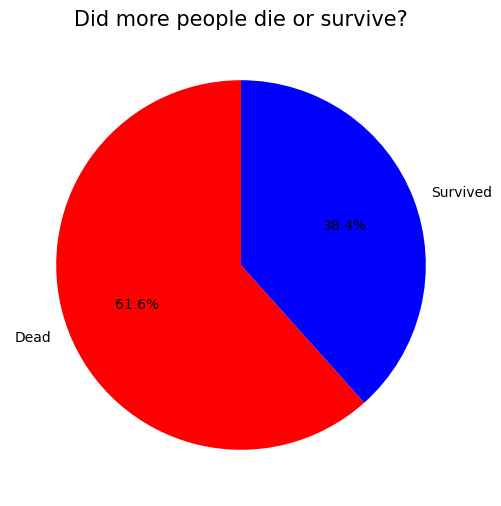

In [259]:
plt.figure(figsize=(6, 6))
titanic['Survived'].value_counts().plot(kind='pie', 
                                        labels=['Dead', 'Survived'], 
                                        autopct='%1.1f%%', 
                                        colors=['red', 'blue'], 
                                        startangle=90)
plt.title('Did more people die or survive?', fontsize=15)
plt.show()

#### 💡​ Interpretation
~ 62 % of the 891 passengers died in the Titanic disaster.

### 3.2. Does Sex affect survival?

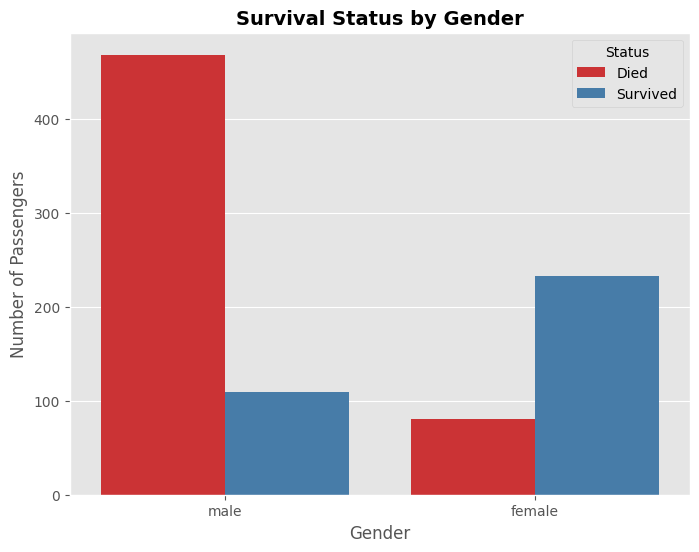

In [260]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(data=titanic, x='Sex', hue='Survived', palette='Set1')

plt.title('Survival Status by Gender', fontsize=14, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

new_labels = ['Died', 'Survived']

# Get the colored boxes from the current legend
handles, _ = ax.get_legend_handles_labels()

# Create a new legend with the proper text
ax.legend(handles, new_labels, title='Status')

plt.show()

As we see the proportion of females that have survived is higher than males. 
But let's be more specific.

In [261]:
males = titanic[titanic['Sex'] == 'male']
females = titanic[titanic['Sex'] == 'female']

df_males = males['Survived'].value_counts().reset_index()
df_females = females['Survived'].value_counts().reset_index()

df_males.columns = ['Status', 'Total']
df_females.columns = ['Status', 'Total']

# 3. Replace 0/1 with Died/Survived
df_males['Status'] = df_males['Status'].replace({0: 'Died', 1: 'Survived'})
df_females['Status'] = df_females['Status'].replace({0: 'Died', 1: 'Survived'})

# Adding the Percentage column
df_males['Percentage'] = (df_males['Total'] / df_males['Total'].sum()) * 100 
df_females['Percentage'] = (df_females['Total'] / df_females['Total'].sum()) * 100 

print("-------------- Men --------------")
print(df_males)
print("\n-------------- Women --------------")
print(df_females)

-------------- Men --------------
     Status  Total  Percentage
0      Died    468   81.109185
1  Survived    109   18.890815

-------------- Women --------------
     Status  Total  Percentage
0  Survived    233   74.203822
1      Died     81   25.796178


#### 💡​ Interpretation
As these statistics show, 74% of women have survived, while only 18% of men have survived.
We can conclude that ***sex affect the survival rate*** which is normal because generally women are prioritized in evacuation.

### 3.3. Does Pclass (Rich vs. Poor) affect survival?

So we have 3 PClasses : 1, 2 and 3. 1 is the best class, 3 is the worst.

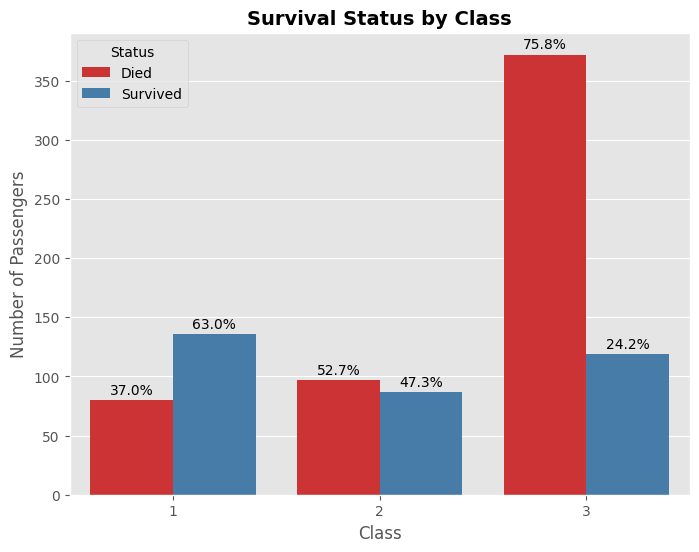

In [262]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(data=titanic, x='Pclass', hue='Survived', palette='Set1')

plt.title('Survival Status by Class', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend(title='Status', labels=['Died', 'Survived'])

# Add percentage labels
class_totals = titanic['Pclass'].value_counts().sort_index().values
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        class_index = int(round(p.get_x()))
        total = class_totals[class_index]
        percentage = (height / total) * 100
        ax.text(x = p.get_x() + p.get_width()/2,  
                y = height + 5,                   
                s = f'{percentage:.1f}%',         
                ha = 'center',                    
                fontsize = 10,
                color = 'black')

plt.show()

#### 💡​ Interpretation
This visualization investigates the relationship between **Socio-Economic Status (Pclass)** and survival rates. The graph reveals a clear correlation between wealth and the likelihood of survival.

* **1st Class (The Wealthy):**
    * This is the **only** group where the number of survivors (Blue) exceeds the number of casualties (Red).
    * Passengers in 1st class had better access to lifeboats and were likely given priority during the evacuation.

* **2nd Class (The Middle Class):**
    * The survival rate is more balanced, but the number of deaths is still slightly higher than survivors.
    * Their location on the ship was likely less favorable than 1st class, but better than 3rd class.

* **3rd Class (The Poor):**
    * **The most tragic statistic.** The red bar (Died) is overwhelmingly high compared to the blue bar (Survived).
    * The vast majority of 3rd-class passengers did not survive. This suggests that being housed deep inside the ship made it difficult to reach the deck in time.




### 3.4. Does age matter ?

To make it easy to read and understand we will create 5 types : Babies, Children, Teenagers, Adults and Seniors.

In [263]:
# 0-5 = Baby, 5-12 = Child, 12-23 = Teenager, 23-60 = Adult, 60-120 = Senior
bins = [0, 5, 12, 23, 60, 120]
labels = ['Baby', 'Child', 'Teenager', 'Adult', 'Senior']

titanic['AgeGroup'] = pd.cut(titanic['Age'], bins=bins, labels=labels, right=False)

# Checking
titanic[['Age', 'AgeGroup']].head(10)

,Age,AgeGroup
0,22.0,Teenager
1,38.0,Adult
2,26.0,Adult
3,35.0,Adult
4,35.0,Adult
5,NaN,NaN
6,54.0,Adult
7,2.0,Baby
8,27.0,Adult
9,14.0,Teenager


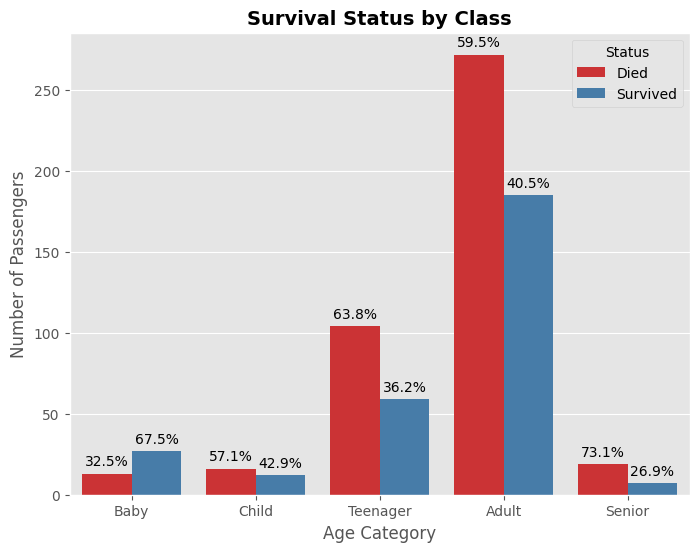

In [264]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(data=titanic, x='AgeGroup', hue='Survived', palette='Set1')

plt.title('Survival Status by Class', fontsize=14, fontweight='bold')
plt.xlabel('Age Category', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend(title='Status', labels=['Died', 'Survived'])

# Add percentage labels
class_totals = titanic['AgeGroup'].value_counts().sort_index().values
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        class_index = int(round(p.get_x()))
        total = class_totals[class_index]
        percentage = (height / total) * 100
        ax.text(x = p.get_x() + p.get_width()/2,  
                y = height + 5,                   
                s = f'{percentage:.1f}%',         
                ha = 'center',                    
                fontsize = 10,
                color = 'black')

plt.show()

#### 💡​ Interpretation

* **Babies (The Protected Class):**
    * **Survival Rate: 67.5%**
    * This is the **only** age group where survivors (Blue) outnumber the dead (Red).
    * This strongly validates the "Women and Children First" maritime protocol, specifically prioritizing infants.

* **Seniors (The Most Vulnerable):**
    * **Survival Rate: 26.9%** (Lowest of all groups)
    * Seniors had the highest probability of dying (73.1%). This could be due to physical inability to reach the boat deck quickly or a lack of priority during evacuation.

* **Children & Teenagers:**
    * Surprisingly, once a child grows past the "Baby" stage, their survival odds drop significantly.
    * **Children:** 42.9% survival rate.
    * **Teenagers:** 36.2% survival rate.
    * This suggests that while babies were carried to safety, older children and teens were often treated more like adults or couldn't be physically carried as easily.

* **Adults (The Majority):**
    * As the largest demographic on the ship, adults bore the highest number of casualties in absolute terms.
    * Around **60% of adults died**, likely because many men (who make up the bulk of this group) sacrificed their spots or were denied access to lifeboats.

#### 📝 Conclusion
Age was a critical survival factor, but it wasn't linear. The data suggests a **"Babies First"** reality rather than a general "Children First" one. If you were a baby, your chances were good; if you were a senior, they were grim.

### 3.5. Does having a family help you ?

In the dataset we have 2 columns : 
1. SibSp : Siblings and spouses
2. Parch : Parents and children

#### 3.5.1. Does having sibling and spouse affect survival ?

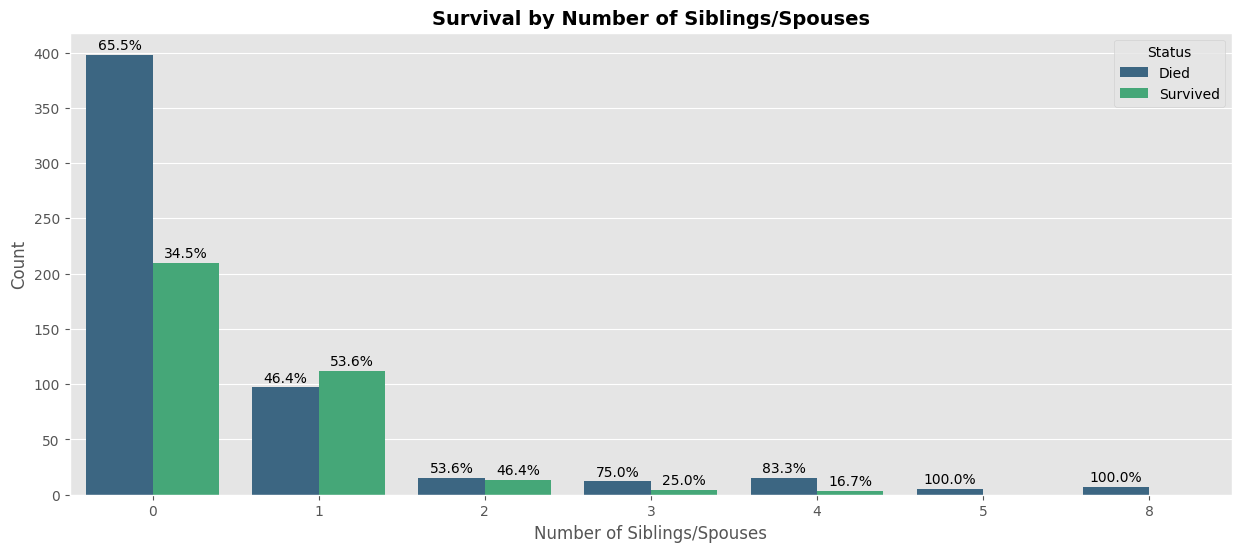

In [265]:
plt.figure(figsize=(15, 6))

ax = sns.countplot(data=titanic, x='SibSp', hue='Survived', palette='viridis')

plt.title('Survival by Number of Siblings/Spouses', fontsize=14, fontweight='bold')
plt.xlabel('Number of Siblings/Spouses', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Status', labels=['Died', 'Survived'])

# Add percentage labels
sibsp_totals = titanic['SibSp'].value_counts().sort_index().values
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        sibsp_index = int(round(p.get_x()))
        total = sibsp_totals[sibsp_index]
        percentage = (height / total) * 100
        ax.text(x = p.get_x() + p.get_width()/2,  
                y = height + 5,                   
                s = f'{percentage:.1f}%',         
                ha = 'center',                    
                fontsize = 10,
                color = 'black')

plt.show()

#### 3.5.2. Does having parents and children affect survival ?

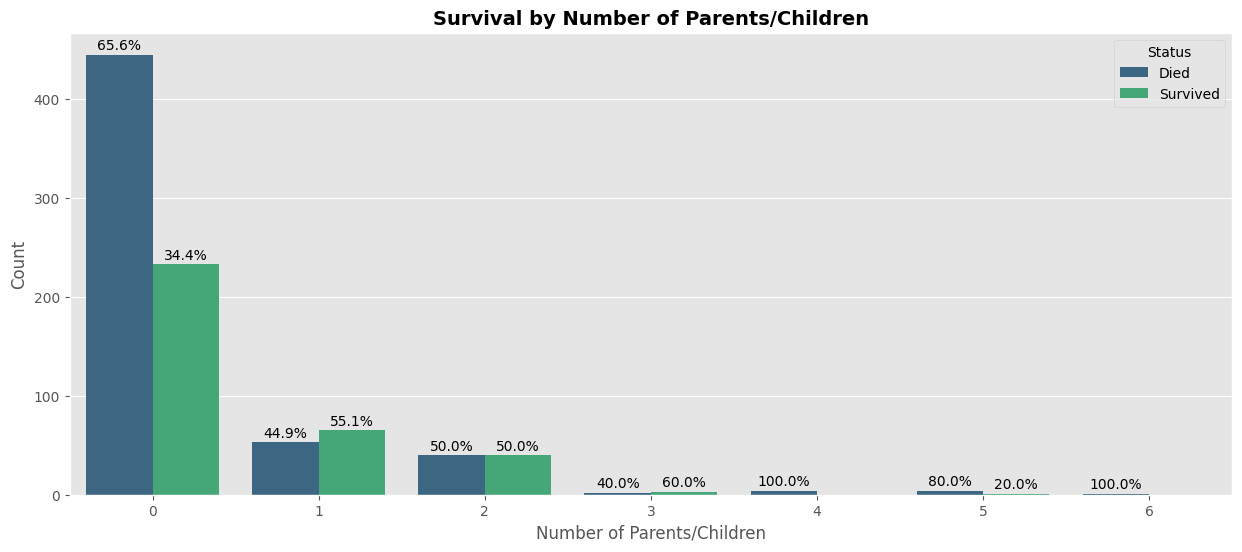

In [266]:
plt.figure(figsize=(15, 6))

ax = sns.countplot(data=titanic, x='Parch', hue='Survived', palette='viridis')

plt.title('Survival by Number of Parents/Children', fontsize=14, fontweight='bold')
plt.xlabel('Number of Parents/Children', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Status', labels=['Died', 'Survived'])

# Add percentage labels
parch_totals = titanic['Parch'].value_counts().sort_index().values
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        parch_index = int(round(p.get_x()))
        total = parch_totals[parch_index]
        percentage = (height / total) * 100
        ax.text(x = p.get_x() + p.get_width()/2,  
                y = height + 5,                   
                s = f'{percentage:.1f}%',         
                ha = 'center',                    
                fontsize = 10,
                color = 'black')

plt.show()

#### 🚨​​ Important
The results from analyzing `Parch` alone might seem counter-intuitive. You might expect a person with 0 Parents/Children to have a specific survival pattern, but the data contradicts this.

**The Missing Piece:**
A passenger with `Parch = 0` isn't necessarily alone—they could be traveling with a spouse or siblings (`SibSp`).

To get the full picture, we need to combine these two variables. Let's create a new column called **`FamilySize`** to represent the total number of people traveling with the passenger.

#### 3.5.3. Combining `Parch` and `SibSp` Columns 

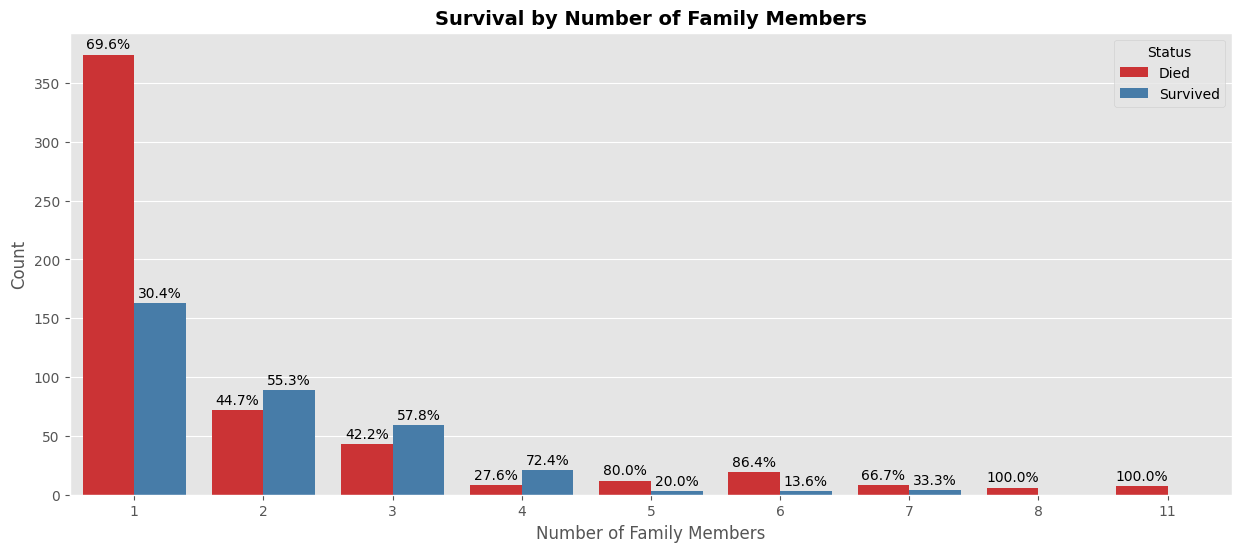

In [267]:
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1
plt.figure(figsize=(15, 6))

ax = sns.countplot(data=titanic, x='FamilySize', hue='Survived', palette='Set1')

plt.title('Survival by Number of Family Members', fontsize=14, fontweight='bold')
plt.xlabel('Number of Family Members', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Status', labels=['Died', 'Survived'])

# Add percentage labels
family_totals = titanic['FamilySize'].value_counts().sort_index().values
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        family_index = int(round(p.get_x()))
        total = family_totals[family_index]
        percentage = (height / total) * 100
        ax.text(x = p.get_x() + p.get_width()/2,  
                y = height + 5,                   
                s = f'{percentage:.1f}%',         
                ha = 'center',                    
                fontsize = 10,
                color = 'black')

plt.show()

#### 💡​ Interpretation
This graph reveals a relationship between group size and survival. The data suggests that **survival was not linear**—it favored those traveling in small groups.

**1. The Solo Travelers (Family Size = 1)**
* **Status:** High Risk ⚠️
* **Observation:** The vast majority of passengers traveled alone but they had a very low survival rate (**30.4%**).

**2. The "Sweet Spot" (Family Size = 2 to 4)**
* **Status:** Highest Chance of Survival ✅
* **Observation:** Survival rates skyrocket for small families.
    * **2 Members:** 55.3% Survived
    * **3 Members:** 57.8% Survived
    * **4 Members:** 72.4% Survived
* **Insight:** Small families could effectively help each other.

**3. The Large Families (Family Size = 5+)**
* **Status:** Critical Danger 🚨
* **Observation:** As soon as the family size hits 5, survival rates crash.
    * **5 Members:** Only 20.0% Survived.
    * **8 & 11 Members:** **0% Survived.** All perished.
* **Insight:** In the chaos of the sinking, trying to keep a group of 6+ people together (especially with panicked children) was nearly impossible. Large families likely refused to separate, leading to tragic outcomes where entire families died together.

**Conclusion:**
Family size was a critical predictor. **Medium-sized families (2-4 people)** had the best survival advantage, while solo travelers and large families faced significantly higher odds of perishing.


### 3.7. Correlation Heatmap

To avoid writing the same code over and over again, we plot the matrix of correlation 

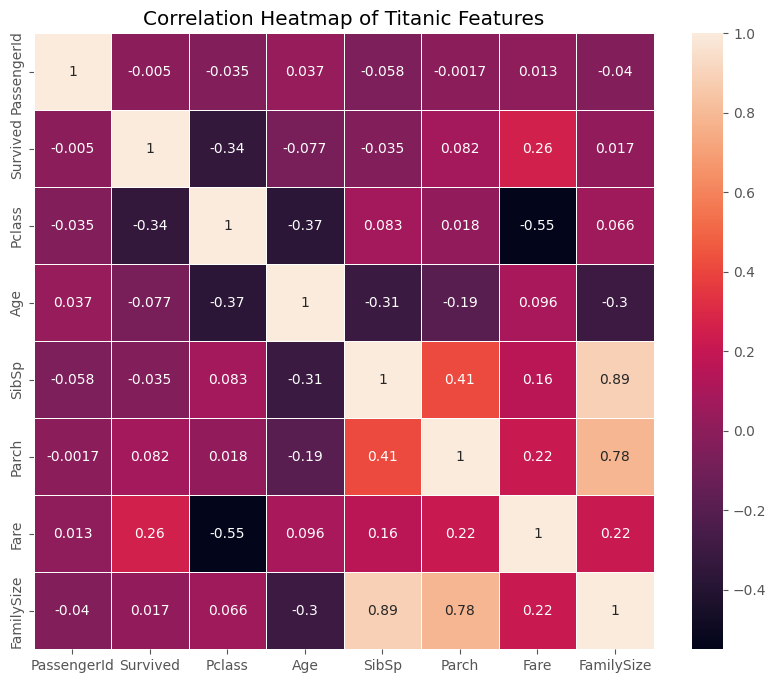

In [268]:
numeric_cols = titanic.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title('Correlation Heatmap of Titanic Features')
plt.show()

---

## 4. 🧹 Data Cleaning & Imputation

### 4.1. Just Exploring

In [269]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
AgeGroup       177
FamilySize       0
dtype: int64

177 values of **`Age`** are missing. But it is the only 'important' column containing missing values.

We have a lot of lost data in **`Cabin`** column, so we will drop it.

We can fill the 2 missing values of **`Embarked`** with the most common value.

### 4.2. Cleaning Code

#### 4.2.1 Drop **`Cabin`** column


In [270]:
titanic.drop(columns=['Cabin'], inplace=True)
print('After removing Cabin column')
print(titanic.columns)

After removing Cabin column
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'AgeGroup', 'FamilySize'],
      dtype='str')


#### 4.2.2 Filling the two missing values in the **`Embarked`** column


In [271]:
most_common_port = titanic['Embarked'].mode()[0]
titanic['Embarked'] = titanic['Embarked'].fillna(most_common_port)

print('After filling null values in Embarked column')
print(titanic['Embarked'].isnull().sum(), 'NaN values')

After filling null values in Embarked column
0 NaN values


#### 4.2.3 Filling the missing values in the **`Age`** column


When we take a look at the name column, we can see that each name has a title. We can use this to create a new column called 'Title' that will contain the title of each passenger.

After that, we can use that column to replace a missing age value by the median age of the passengers with the same title.

In [272]:
titanic['Title'] = titanic['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Replace rare titles with 'Rare' and translated titles to English
titanic['Title'] = titanic['Title'].replace(['Lady', 'Countess','Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic['Title'] = titanic['Title'].replace('Mme', 'Mrs')
titanic['Title'] = titanic['Title'].replace(['Mlle', 'Ms'], 'Miss')

print('------- Title Column -------')
print(titanic['Title'].value_counts())

------- Title Column -------
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


So now, **`Title`** column works this way :

- Mr : Adult Men
- Mrs : Married Women
- Miss : Unmarried Women or Young Women
- Master : Boys
- Rare : All the other titles


In [273]:
titanic['Age'] = titanic['Age'].fillna(titanic.groupby('Title')['Age'].transform('median'))

print(f"Missing Ages: {titanic['Age'].isnull().sum()}")

Missing Ages: 0


In [274]:
# Adding the missing data in te AgeGroup column (this column is related to Age,
#  it is normal taht it had NaN values

titanic['AgeGroup'] = titanic['AgeGroup'].fillna(pd.cut(titanic['Age'], 
                                                        bins=bins, 
                                                        labels=labels, 
                                                        right=False))

In [275]:
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
AgeGroup       0
FamilySize     0
Title          0
dtype: int64

##### All Done !

---

## 5. 🏗️ Feature Engineering

### 5.1. Creating an `FamilyGroup` Column

**Observation from EDA (Section 3.5.3):**
The relationship between `FamilySize` and survival is **non-linear**. It follows a specific "Goldilocks" pattern where being alone is bad, being in a huge group is bad, but being in a small group is optimal.

* **Solo (Size 1):** Low Survival ❌  
* **Small (Size 2-4):** High Survival ✅
* **Large (Size 5+):** Low Survival ❌

**Strategy:**
To help the machine learning model understand this pattern easily, we will group the raw `FamilySize` numbers into three distinct categories in a new column called **`FamilyGroup`**:
1.  **Solo**
2.  **Small**
3.  **Large**

In [276]:
titanic['FamilyGroup'] = 'Solo'


def getGroup(size) :
    if size == 1 :
        return 'Solo'
    elif 2 <= size <= 4 :
        return 'Small'
    else :
        return 'Large'

titanic['FamilyGroup'] =  titanic['FamilySize'].apply(getGroup) 

titanic['FamilyGroup'].value_counts()

FamilyGroup
Solo     537
Small    292
Large     62
Name: count, dtype: int64

### 5.2. Creating an `FareBand` Column

The correlation matrix shows that `Fare` is the strongest positive predictor of survival (**0.26**).

**Why create `FareBand`?**
While the relationship is clear, the raw `Fare` values vary wildly. By grouping these prices into bands (Low, Medium, High), we transform complex numerical noise into clear, ordinal categories that are easier for the model to learn from.

The best scientific method is to use Quartiles (splitting the passengers into 4 equal groups: the poorest 25%, the middle-class, and the richest 25%)

In [277]:
print(titanic['Fare'].describe())

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


In [278]:
titanic['FareBand'] = 'Low'

def getFareBand(price):
    if price <= 7.91:
        return 'Low'
    elif price <= 14.454:
        return 'Medium'
    elif price <= 31.0:
        return 'High'
    else:
        return 'VeryHigh'

titanic['FareBand'] = titanic['Fare'].apply(getFareBand)

print(titanic['FareBand'].value_counts())

FareBand
High        229
Low         223
VeryHigh    222
Medium      217
Name: count, dtype: int64


In [279]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup,FamilySize,Title,FamilyGroup,FareBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Teenager,2,Mr,Small,Low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,2,Mrs,Small,VeryHigh
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Adult,1,Miss,Solo,Medium
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Adult,2,Mrs,Small,VeryHigh
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Adult,1,Mr,Solo,Medium


We have successfully transformed our raw data into powerful new features that will help our machine learning model "see" the patterns we discovered.

#### 🔙 A Note on Iterative Workflow
**Don't forget:** We actually started our feature engineering early!
* Features like **`FamilySize`**, **`Title`**, and **`AgeGroup`** were technically created during the **EDA (Detective) Phase**.
* This is a normal part of Data Science: we often need to build new features *during* exploration just to visualize the data effectively.
* Now, all these features—both the early ones and the new ones—are ready for the final step.

---

## 6. 🔢 Preprocessing & Encoding

Our dataset is now rich with information, but much of it is still text. Computers only understand numbers.

It is time to convert everything into a format our model can read.

### 6.1. Label Encoding the `Sex` Column

In [280]:
sex_mapping = {"male": 0, "female": 1}
titanic['Sex'] = titanic['Sex'].map(sex_mapping)

print('---- New Sex Column ----')
titanic['Sex'].head()

---- New Sex Column ----


0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64

### 6.2. Mapping `Embarked` and `Title` Columns

In [281]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4}

titanic['Embarked'] = titanic['Embarked'].map(embarked_mapping)
titanic['Title'] = titanic['Title'].map(title_mapping)

### 6.3. Mapping `AgeGroup`, `Fareband` and `FamilyGroup` Columns

In these columns, **order matters** !

In [282]:
age_mapping = {"Baby": 0, "Child": 1, "Teenager": 2, "Adult": 3, "Senior": 4}
fare_mapping = {"Low": 0, "Medium": 1, "High": 2, "VeryHigh": 3}
family_mapping = {"Solo": 0, "Small": 1, "Large": 2}

titanic['AgeGroup'] = titanic['AgeGroup'].map(age_mapping)
titanic['FareBand'] = titanic['FareBand'].map(fare_mapping)
titanic['FamilyGroup'] = titanic['FamilyGroup'].map(family_mapping)

### 6.4. Verification

In [283]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup,FamilySize,Title,FamilyGroup,FareBand
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,2,2,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1,3,2,2,1,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,3,1,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,0,3,2,2,1,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,3,1,0,0,1


### 6.5. Dropping unuseful columns

In [284]:
titanic = titanic.drop(['PassengerId', 
                        'Name', 
                        'Ticket', 
                        'SibSp', 
                        'Parch', 
                        'Age', 
                        'Fare', 
                        'FamilySize'], axis=1)

### 6.6. Final Verification

In [285]:
print("-------------- Final Dataset Shape --------------")
print(titanic.shape)
print("\n-------------- First 5 Rows --------------")
print(titanic.head())

-------------- Final Dataset Shape --------------
(891, 8)

-------------- First 5 Rows --------------
   Survived  Pclass  Sex  Embarked AgeGroup  Title  FamilyGroup  FareBand
0         0       3    0         0        2      0            1         0
1         1       1    1         1        3      2            1         3
2         1       3    1         0        3      1            0         1
3         1       1    1         0        3      2            1         3
4         0       3    0         0        3      0            0         1


### 6.7. New Correlation Matrix

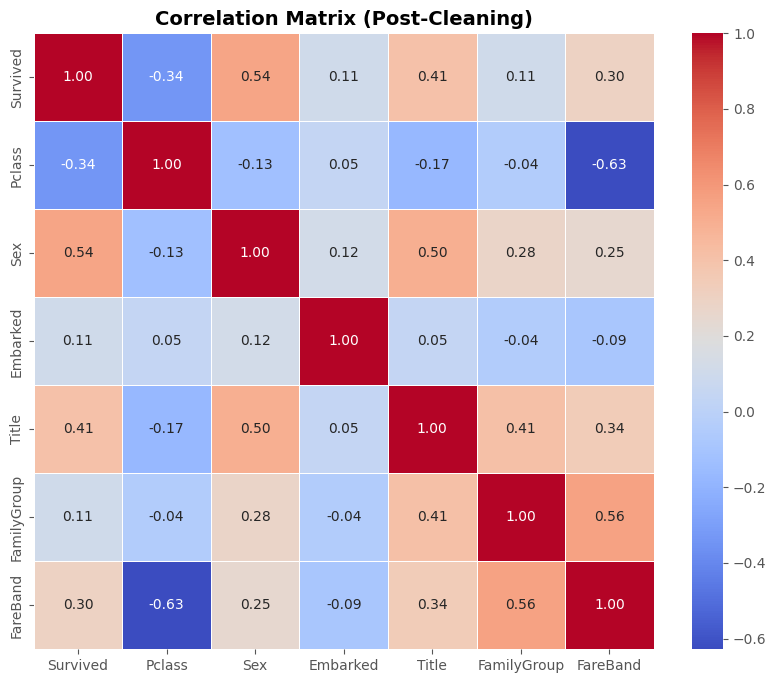

In [286]:
numeric_df = titanic.select_dtypes(include=['number'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Post-Cleaning)', fontsize=14, fontweight='bold')
plt.show()

## 7. 🤖 Model Building 

### 7.1. RandomForestClassifier Model

Random Forest is an ensemble learning algorithm that builds multiple decision trees and merges them together to get a more accurate and stable prediction. Instead of relying on one single tree, which might be biased, it creates a "forest" where each tree votes on the outcome, and the majority wins. This "wisdom of the crowd" strategy significantly reduces the risk of overfitting and ensures that the model generalizes better to new, unseen data.

In [287]:
features = ['Pclass', 'Sex', 'Title', 'FamilyGroup', 'AgeGroup', 'FareBand', 'Embarked']

# Choosing the Prediction Target
y = titanic.Survived

# Choosing the features
X = titanic.drop('Survived', axis=1)

# Split Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
# n_estimators=100 means "Use 100 different trees"
titanic_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit model
titanic_model.fit(X_train, y_train)

# Test on the Validation Data
predictions = titanic_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)*100} %")

Accuracy: 82.12290502793296 %


We've got an 82% accuracy with default settings.

Let's use **GridSearchCV** tool to tell us which are the best parameters to use

### 7.2. Optimizing the parameters using **GridSearchCV**

In [288]:
# define the settings to try
param_grid = {
    'n_estimators': [100, 200, 300],  # How many trees?
    'max_depth': [5, 10, None],       # How deep can they grow?
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum samples required at a leaf node
}

# Setup the Grid Search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, verbose=1)

# Run the Search
grid_search.fit(X_train, y_train)

print(f"Best Score: {grid_search.best_score_ * 100} %")
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Score: 83.56249384418399 %
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


### 7.3. Final Model

In [289]:
features = ['Pclass', 'Sex', 'Title', 'FamilyGroup', 'AgeGroup', 'FareBand', 'Embarked']

# Choosing the Prediction Target
y = titanic.Survived

# Choosing the features
X = titanic[features]

# Split Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
# n_estimators=100 means "Use 100 different trees"
titanic_model = RandomForestClassifier(
                                n_estimators=200, 
                                max_depth=5, 
                                min_samples_leaf=4,
                                min_samples_split=2,  
                                random_state=42)

# Fit model
titanic_model.fit(X_train, y_train)

# Test on the Validation Data
predictions = titanic_model.predict(X_test)
print(f"Best Accuracy: {accuracy_score(y_test, predictions)*100} %")

Best Accuracy: 83.24022346368714 %


---

## 8. 🚀 Deployment & Submission

### 8.1. Loading Test Data

In [290]:
test_data = pd.read_csv("test.csv")

### 8.2. Pipeline to clean the test Data

In [291]:
passenger_ids = test_data['PassengerId']


test_data['Title'] = test_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_data['Title'] = test_data['Title'].replace(['Mlle', 'Ms'], 'Miss')
test_data['Title'] = test_data['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4}
test_data['Title'] = test_data['Title'].map(title_mapping)

sex_mapping = {"male": 0, "female": 1}
test_data['Sex'] = test_data['Sex'].map(sex_mapping)

test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data['FamilyGroup'] = 'Solo'
test_data.loc[(test_data['FamilySize'] >= 2) & (test_data['FamilySize'] <= 4), 'FamilyGroup'] = 'Small'
test_data.loc[test_data['FamilySize'] >= 5, 'FamilyGroup'] = 'Large'
family_mapping = {"Solo": 0, "Small": 1, "Large": 2}
test_data['FamilyGroup'] = test_data['FamilyGroup'].map(family_mapping)

test_data['Age'] = test_data['Age'].fillna(test_data.groupby('Title')['Age'].transform('median'))

test_data.loc[ test_data['Age'] <= 5, 'AgeGroup'] = 0   # Baby
test_data.loc[(test_data['Age'] > 5) & (test_data['Age'] <= 12), 'AgeGroup'] = 1  # Child
test_data.loc[(test_data['Age'] > 12) & (test_data['Age'] <= 18), 'AgeGroup'] = 2 # Teen
test_data.loc[(test_data['Age'] > 18) & (test_data['Age'] <= 60), 'AgeGroup'] = 3 # Adult
test_data.loc[ test_data['Age'] > 60, 'AgeGroup'] = 4   # Senior

test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median()) # Test set has 1 missing fare

test_data.loc[ test_data['Fare'] <= 7.91, 'FareBand'] = 0
test_data.loc[(test_data['Fare'] > 7.91) & (test_data['Fare'] <= 14.454), 'FareBand'] = 1
test_data.loc[(test_data['Fare'] > 14.454) & (test_data['Fare'] <= 31), 'FareBand'] = 2
test_data.loc[ test_data['Fare'] > 31, 'FareBand'] = 3

embarked_mapping = {"S": 0, "C": 1, "Q": 2}
test_data['Embarked'] = test_data['Embarked'].map(embarked_mapping)

# --- FINAL SELECTION ---
features = ['Pclass', 'Sex', 'Title', 'FamilyGroup', 'AgeGroup', 'FareBand', 'Embarked']
X_test_final = test_data[features]

print("✅ Test Data Ready!")
print(X_test_final.head())

✅ Test Data Ready!
   Pclass  Sex  Title  FamilyGroup  AgeGroup  FareBand  Embarked
0       3    0      0            0       3.0       0.0         2
1       3    1      2            1       3.0       0.0         0
2       2    0      0            0       4.0       1.0         2
3       3    0      0            0       3.0       1.0         0
4       3    1      2            1       3.0       1.0         0


### 8.3. Prediction

In [292]:
predictions = titanic_model.predict(X_test_final)

# Create Submission DataFrame
output = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})
output.to_csv('submission_tuned.csv', index=False)
print("Submission file is saved as 'submission_tuned.csv'")

Submission file is saved as 'submission_tuned.csv'


### 8.4. Submitting to Kaggle to test accuracy

![Kaggle Score](submission_score.png)

As we see, accuracy dropped from 83% to 78%. 

This may be because of **overfitting** or **The Model** itself.